## Week 6 notebook

Include concepts such as decision trees and random forests on your datasets

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature engineering and selection libraries
from sklearn.ensemble import RandomForestClassifier

# data preprocesing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Classification metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report, precision_score, recall_score

results = {}

random_state = 0

In [2]:
def encoding(df_or_series, target=None, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        target: Column name (or iterable of names) to leave untouched when encoding a DataFrame.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: encoded DataFrame (and optionally mappings for label encoding).
        If input is Series: encoded Series.
    """
    # Normalize target parameter into a set for quick exclusion checks
    if target is None:
        target_cols = set()
    elif isinstance(target, (list, tuple, set)):
        target_cols = set(target)
    else:
        target_cols = {target}

    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded

    elif isinstance(df_or_series, pd.DataFrame):
        df_encoded = df_or_series.copy()

        if one_hot:
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            cat_cols = [c for c in cat_cols if c not in target_cols]
            return pd.get_dummies(df_encoded, columns=cat_cols, drop_first=True)

        if cat_cols is None:
            cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
        cat_cols = [c for c in cat_cols if c not in target_cols]

        mappings = {}
        for col in cat_cols:
            uniques = df_encoded[col].dropna().unique().tolist()
            mapping = {cat: code for code, cat in enumerate(uniques)}
            mappings[col] = mapping
            df_encoded[col] = df_encoded[col].map(mapping).astype("int64")

        return df_encoded

    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [3]:
# Create a function to load and split data
def split_data(df: pd.DataFrame, target=None, test_size=0.2, random_state=random_state, choice='norm'):

    # Feature and target
    X = df.drop(columns=target)
    y = df[target]

    # Train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

    y_train = np.asarray(y_train).ravel()
    y_test = np.asarray(y_test).ravel()
    
    if choice == 'reg':
        # Regularize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled features back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    else:
        # Bormalize the features
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled features back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, df

In [4]:
def gridsearchcv(model, X_train, y_train, param_dict=None, random_state=random_state, scoring='recall', cv=None):
    """
    Generic grid search function for any sklearn model and parameter grid.

    Args:
        model: The sklearn model class (not an instance), e.g., SVC, RandomForestClassifier, etc.
        X_train: Training features.
        y_train: Training target.
        param_dict: Dictionary of parameter grid for the model.
        random_state: Random state for reproducibility.
        scoring: Scoring metric for GridSearchCV.
        cv: Cross-validation strategy (optional).

    Returns:
        grid_best_params: Best parameter dictionary.
        grid_cv_score: Best cross-validated score.
    """    
    # If the model supports random_state, pass it; otherwise, ignore
    try:
        base_model = model(random_state=random_state)
    except TypeError:
        base_model = model()

    # Use provided cv or default to RepeatedStratifiedKFold for classification
    if cv is None:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)

    search = GridSearchCV(
        estimator=base_model,
        param_grid=param_dict,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
        error_score='raise'
    )

    search.fit(X_train, y_train)

    # Extract results into a DataFrame
    results = pd.DataFrame(search.cv_results_)

    # Print top 5 results (show all param columns dynamically)
    param_cols = [col for col in results.columns if col.startswith('param_')]
    display_cols = param_cols + [
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]
    results = results[display_cols].sort_values(by='rank_test_score')
    renamed_results = results.rename(
        columns={col: col.replace('param_', '') for col in param_cols} |
                {'mean_test_score': 'mean_cv_score', 'std_test_score': 'std_cv_score'}
    ).drop(columns=['rank_test_score'])

    print("\nSearch Results (Top 5):\n")
    print(renamed_results.head(5).to_string(index=False))

    # Best parameters and test performance
    grid_best_params = search.best_params_
    print(f"\nBest Parameters: {grid_best_params}")
    grid_cv_score = search.best_score_
    print(f"Best CV Score: {grid_cv_score:.4f}")

    return grid_best_params, grid_cv_score

In [5]:
# Load the cleaned datasets
df_ins = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\insurance_claims_cleaned.csv')

In [6]:
# Encode the datasets
df_ins_encoded = encoding(df_ins, one_hot=False)
df_ins_oh = encoding(df_ins, one_hot=True)

In [7]:
# Regularized data
X_train_ins_reg, X_test_ins_reg, y_train_ins_reg, y_test_ins_reg, df_ins_reg = split_data(df_ins_encoded, target='fraud_reported', choice='reg')

# Regularized One-hot data
X_train_ins_oh_reg, X_test_ins_oh_reg, y_train_ins_oh_reg, y_test_ins_oh_reg, df_ins_oh_reg = split_data(df_ins_oh, target='fraud_reported', choice='reg')

In [8]:
# Run Grid search on the ins claims dataset
rf_ins_params = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'max_depth': range(3,20),
    'min_samples_split': range(2,5),
    'class_weight': ['balanced']
}

ins_reg_rf_grid_best_params, ins_reg_rf_grid_cv_score = gridsearchcv(
    RandomForestClassifier, X_train_ins_reg, y_train_ins_reg, param_dict=rf_ins_params, scoring='recall')


Search Results (Top 5):

class_weight  max_depth  min_samples_split  n_estimators  mean_cv_score  std_cv_score  mean_train_score  std_train_score
    balanced          3                  2            10       0.659949      0.089320          0.707585         0.022942
    balanced          3                  3            10       0.659949      0.089320          0.707585         0.022873
    balanced          3                  4            10       0.659949      0.089320          0.707585         0.022873
    balanced          3                  2           500       0.657923      0.088407          0.756790         0.026077
    balanced          3                  3           500       0.656897      0.089336          0.756788         0.024964

Best Parameters: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 10}
Best CV Score: 0.6599


In [9]:
# Run Grid search on the ins claims dataset
rf_ins_oh_params = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'max_depth': range(3,20),
    'min_samples_split': range(2,5),
    'class_weight': ['balanced']
}

ins_reg_oh_rf_grid_best_params, ins_reg_oh_rf_grid_cv_score = gridsearchcv(
    RandomForestClassifier, X_train_ins_oh_reg, y_train_ins_oh_reg, param_dict=rf_ins_oh_params, scoring='recall')


Search Results (Top 5):

class_weight  max_depth  min_samples_split  n_estimators  mean_cv_score  std_cv_score  mean_train_score  std_train_score
    balanced          3                  3           200       0.758718      0.051200          0.876747         0.020800
    balanced          3                  2           200       0.756718      0.051089          0.876241         0.021028
    balanced          3                  4           200       0.756667      0.051762          0.875986         0.022140
    balanced          3                  4          1000       0.754564      0.046062          0.878530         0.022977
    balanced          3                  3          1000       0.754513      0.046380          0.878530         0.022767

Best Parameters: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 200}
Best CV Score: 0.7587


In [10]:
def classifier_model(model_class, X_train, y_train, X_test, y_test, title=None, random_state=random_state, **model_params):
    """
    Generic function to fit and evaluate any sklearn classifier model.

    Args:
        model_class: The sklearn classifier class (e.g., RandomForestClassifier, DecisionTreeClassifier).
        X_train, y_train: Training data.
        X_test, y_test: Test data.
        model_params: Parameters for the classifier.

    Prints:
        Classification report, accuracy, F1 score, and confusion matrix plot.

    Returns:
        model: The fitted model.
        y_pred: The predictions on X_test.
    """
    if title == None:
        raise ValueError("Input a tile for the run")
    
    model = model_class(random_state=random_state, **model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    clf_name = model_class.__name__

    # Print the classification report
    report = classification_report(y_test, y_pred, output_dict=False)
    print(f"Classification Report for {clf_name}:")
    print(report)
    print("\n")

    # Calculate accuracy, f1, precision, and recall
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print(f"{clf_name} Accuracy: {accuracy:.2f}")
    print(f"{clf_name} F1 score: {f1:.2f}")
    print(f"{clf_name} Precision: {precision:.2f}")
    print(f"{clf_name} Recall: {recall:.2f}")
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {clf_name}')
    plt.tight_layout()
    plt.show()

    # Save the results to results dictionary
    results[title] = {
        'model_name': clf_name,
        'model_params': model.get_params(),
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    }

    return model, y_pred, results

## Insurance Claims Results

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       151
           1       0.57      0.27      0.36        49

    accuracy                           0.77       200
   macro avg       0.68      0.60      0.61       200
weighted avg       0.74      0.77      0.74       200



RandomForestClassifier Accuracy: 0.77
RandomForestClassifier F1 score: 0.74
RandomForestClassifier Precision: 0.74
RandomForestClassifier Recall: 0.77


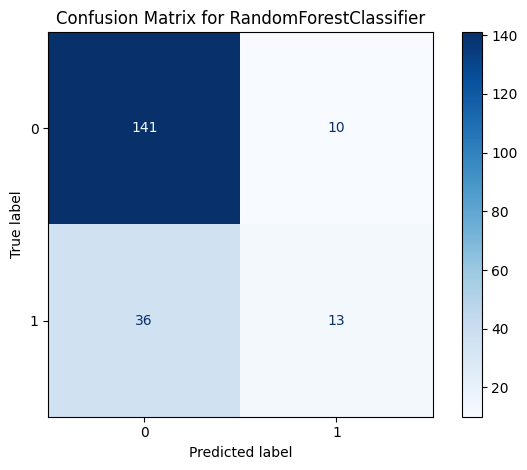

In [11]:
# Baseline Random Forest Classifier
base_ins_reg_model, base_ins_reg_pred, base_ins_reg_results = classifier_model(RandomForestClassifier,
                                                                               X_train_ins_reg,
                                                                               y_train_ins_reg,
                                                                               X_test_ins_reg,
                                                                               y_test_ins_reg,
                                                                               title = 'Baseline Random Forest with Regularized features')

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.77      0.98      0.87       151
           1       0.67      0.12      0.21        49

    accuracy                           0.77       200
   macro avg       0.72      0.55      0.54       200
weighted avg       0.75      0.77      0.70       200



RandomForestClassifier Accuracy: 0.77
RandomForestClassifier F1 score: 0.70
RandomForestClassifier Precision: 0.75
RandomForestClassifier Recall: 0.77


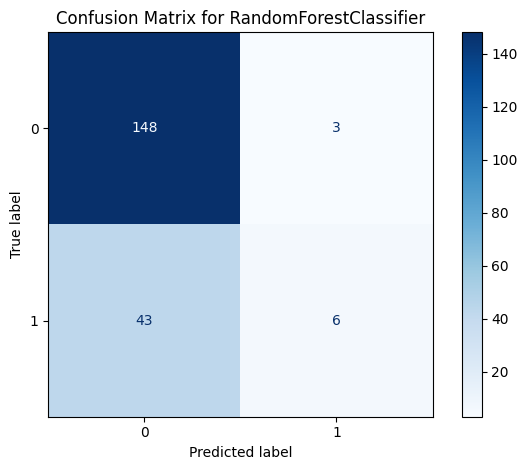

In [12]:
# Baseline Random Forest Classifier
base_ins_oh_reg_model, base_ins_oh_reg_pred, base_ins_oh_reg_results = classifier_model(RandomForestClassifier,
                                                                               X_train_ins_oh_reg,
                                                                               y_train_ins_oh_reg,
                                                                               X_test_ins_oh_reg,
                                                                               y_test_ins_oh_reg,
                                                                               title = 'Baseline Random Forest with One-hot encoded, Regularized features')

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       151
           1       0.57      0.71      0.64        49

    accuracy                           0.80       200
   macro avg       0.74      0.77      0.75       200
weighted avg       0.82      0.80      0.81       200



RandomForestClassifier Accuracy: 0.80
RandomForestClassifier F1 score: 0.81
RandomForestClassifier Precision: 0.82
RandomForestClassifier Recall: 0.80


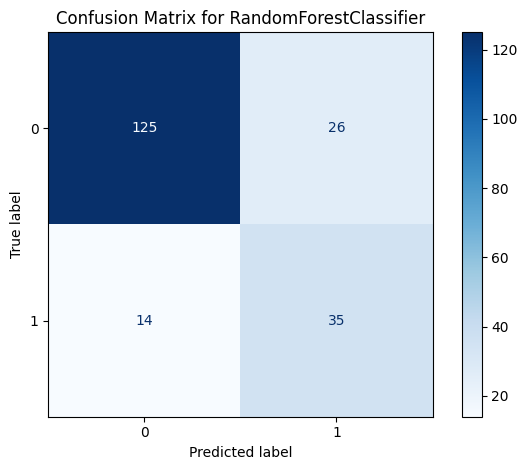

In [13]:
# run evaluation on the ins dataset
grid_ins_reg_model, grid_ins_reg_pred, grid_ins_reg_results = classifier_model(RandomForestClassifier,
                                                                               X_train_ins_reg,
                                                                               y_train_ins_reg,
                                                                               X_test_ins_reg,
                                                                               y_test_ins_reg,
                                                                               title = 'Custom Random Forest with regularized features and gridsearch parameters',
                                                                               **ins_reg_rf_grid_best_params)

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       151
           1       0.48      0.76      0.59        49

    accuracy                           0.74       200
   macro avg       0.69      0.75      0.70       200
weighted avg       0.80      0.74      0.76       200



RandomForestClassifier Accuracy: 0.74
RandomForestClassifier F1 score: 0.76
RandomForestClassifier Precision: 0.80
RandomForestClassifier Recall: 0.74


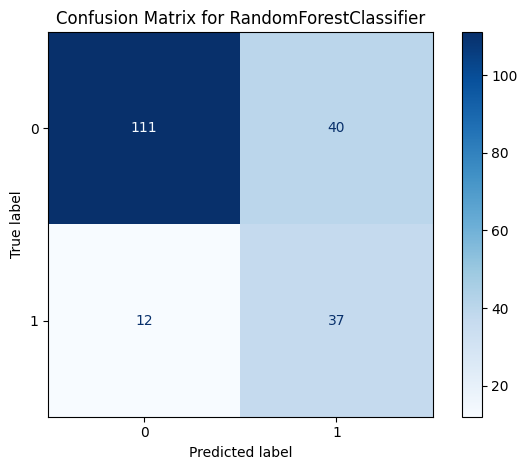

In [14]:
# run evaluation on the ins dataset
grid_ins_oh_reg_model, grid_ins_oh_reg_pred, grid_ins_oh_reg_results = classifier_model(RandomForestClassifier,
                                                                               X_train_ins_oh_reg,
                                                                               y_train_ins_oh_reg,
                                                                               X_test_ins_oh_reg,
                                                                               y_test_ins_oh_reg,
                                                                               title = 'Custom Random Forest with One-hot encoded, regularized features and gridsearch parameters',
                                                                               **ins_reg_oh_rf_grid_best_params)

In [15]:
results = pd.DataFrame(results)
results

,Baseline Random Forest with Regularized features,"Baseline Random Forest with One-hot encoded, Regularized features",Custom Random Forest with regularized features and gridsearch parameters,"Custom Random Forest with One-hot encoded, regularized features and gridsearch parameters"
model_name,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier
model_params,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
accuracy,0.77,0.77,0.8,0.74
f1_score,0.737588,0.70414,0.806771,0.755604
precision,0.739919,0.74836,0.819531,0.799069
recall,0.77,0.77,0.8,0.74


In [16]:
# Highlight feature importance for the best model
feature_imp_df = pd.DataFrame({
                            'Feature': X_train_ins_reg.columns,
                            'Value':grid_ins_reg_model.feature_importances_
                            })

feature_imp_df.sort_values(by='Value', ascending=False)

,Feature,Value
19,incident_severity,0.507240
32,vehicle_claim,0.089598
12,insured_hobbies,0.064916
29,total_claim_amount,0.060356
34,auto_model,0.032819
0,Unnamed: 0,0.029716
1,months_as_customer,0.025783
6,policy_annual_premium,0.025725
30,injury_claim,0.024206
8,insured_zip,0.018441
